# Model testing via Lightning checkpoints

In [3]:
from functools import partial
import torch
import torchvision

batch_size = 64

dataset_split = "mnist"
dataset = partial(torchvision.datasets.EMNIST, split=dataset_split)
data_test = dataset(
    root="../eqprop/data",
    train=False,
    download=True,
)
dataset_test = torch.utils.data.TensorDataset(
    (data_test.data / 255).unsqueeze(1).flatten(start_dim=1).cuda(),
    torch.nn.functional.one_hot(data_test.targets).to(torch.float32).cuda(),
)

loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, drop_last=True
)

In [20]:
import wandb
import lightning
from tqdm.notebook import tqdm

# import sys
# sys.path.insert(0, '..')

from custom_callbacks.track_log_relative_residual_callback import TrackLogRelativeResidualCallback
from litonematrixdeq import LitOneMatrixDEQ
from litevenodddeq import LitEvenOddDEQ

api = wandb.Api()

logger = lightning.pytorch.loggers.WandbLogger(
    project="HopDEQ",
    entity="hopfield",
    mode='disabled'
    )

trainer = lightning.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[
        TrackLogRelativeResidualCallback(),
    ],
    enable_progress_bar=False,
)

def runs_from_sweep(sweep):
    all_rel_res = {}

    runs = sweep.runs
    for run in tqdm(runs):
        # .name is the human-readable name of the run.
        print(run.name, run.id)

        # User settings
        nr_of_layers = run.config["nr_of_layers"]

        # if nr_of_layers != 7: #select for specific architecture
        #     continue #move to the next run

        match nr_of_layers:
            case 3:
                lr = 0.01
                layers = [784, 1990, 10]
            case 5:
                lr = 0.005
                layers = [784, 1280, 510, 200, 10]
            case 7:
                lr = 0.005
                layers = [784, 1024, 512, 256, 128, 70, 10]
        
        damping_factor=0.5 * (not run.config["HAM"] and not run.config["EvenOdd"]) #only for Hop!

        # Deeper requires more time steps
        # Damped means slowed down in time, so more time step required too
        iter_scaling_factor = int((nr_of_layers // 2)/(1-damping_factor))

        if run.config["AA"]:
            deq_kwargs = dict(
                forward_kwargs=dict(
                    solver="anderson",
                    iter=40 * iter_scaling_factor,
                ),
                backward_kwargs=dict(
                    solver="picard",
                    iter=8 * iter_scaling_factor,
                    method="backprop",
                ),
                damping_factor=damping_factor,
            )
        else:
            deq_kwargs = dict(
                forward_kwargs=dict(
                    solver="picard",
                    iter=40 * iter_scaling_factor,
                ),
                backward_kwargs=dict(
                    solver="picard",
                    iter=8 * iter_scaling_factor,
                    method="backprop",
                ),
                damping_factor=damping_factor,
            )

        config = dict(
            batch_size=batch_size,
            lr=lr,  # with decay to lr/10
            layers=layers,
            deq_kwargs=deq_kwargs,
            ham=run.config["HAM"],
        )

        if run.config["EvenOdd"]:
            hop = LitEvenOddDEQ(**config)
        else:
            hop = LitOneMatrixDEQ(**config)

        # model_path = f"HopDEQ/{run.id}/checkpoints/epoch=9-step=9370.ckpt"
        # model_path = f"HopDEQ/{run.id}/checkpoints/epoch=3-step=3748.ckpt"
        model_path = f"HopDEQ/{run.id}/checkpoints/epoch=2-step=2811.ckpt"
        trainer.test(model=hop, ckpt_path=model_path, dataloaders=loader_test, verbose=False)
        rel_res = trainer.callbacks[0].all_rel_res

        key = (run.config["EvenOdd"], run.config["AA"])
        if key not in all_rel_res:
            all_rel_res[key] = rel_res
        else:
            all_rel_res[key].extend(rel_res)
        
    return all_rel_res

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
all_rel_res1 = runs_from_sweep(api.sweep("hopfield/HopDEQ/sweeps/s7xtidn9"))

  0%|          | 0/20 [00:00<?, ?it/s]

Restoring states from the checkpoint path at HopDEQ/8ibasi5y/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/8ibasi5y/checkpoints/epoch=9-step=9370.ckpt


comfy-sweep-20 8ibasi5y


/media/cmgoemae/micromamba/envs/EqProp_node1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Restoring states from the checkpoint path at HopDEQ/j47wp20m/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/j47wp20m/checkpoints/epoch=9-step=9370.ckpt


grateful-sweep-19 j47wp20m


Restoring states from the checkpoint path at HopDEQ/cgexvunj/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/cgexvunj/checkpoints/epoch=9-step=9370.ckpt


lunar-sweep-18 cgexvunj


Restoring states from the checkpoint path at HopDEQ/kw1ko4uc/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/kw1ko4uc/checkpoints/epoch=9-step=9370.ckpt


fast-sweep-17 kw1ko4uc


Restoring states from the checkpoint path at HopDEQ/aa1uii2u/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/aa1uii2u/checkpoints/epoch=9-step=9370.ckpt


eager-sweep-16 aa1uii2u


Restoring states from the checkpoint path at HopDEQ/fqfpehs5/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/fqfpehs5/checkpoints/epoch=9-step=9370.ckpt


comic-sweep-15 fqfpehs5


Restoring states from the checkpoint path at HopDEQ/lsh0eyet/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/lsh0eyet/checkpoints/epoch=9-step=9370.ckpt


atomic-sweep-14 lsh0eyet


Restoring states from the checkpoint path at HopDEQ/9esvqz3c/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/9esvqz3c/checkpoints/epoch=9-step=9370.ckpt


vital-sweep-13 9esvqz3c


Restoring states from the checkpoint path at HopDEQ/5rf9w6bp/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/5rf9w6bp/checkpoints/epoch=9-step=9370.ckpt


summer-sweep-12 5rf9w6bp


Restoring states from the checkpoint path at HopDEQ/u7jx2wg3/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/u7jx2wg3/checkpoints/epoch=9-step=9370.ckpt


pleasant-sweep-11 u7jx2wg3


Restoring states from the checkpoint path at HopDEQ/q7ozvc3l/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/q7ozvc3l/checkpoints/epoch=9-step=9370.ckpt


likely-sweep-10 q7ozvc3l


Restoring states from the checkpoint path at HopDEQ/cml7i0a6/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/cml7i0a6/checkpoints/epoch=9-step=9370.ckpt


dandy-sweep-9 cml7i0a6


Restoring states from the checkpoint path at HopDEQ/4hc7vzls/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/4hc7vzls/checkpoints/epoch=9-step=9370.ckpt


dazzling-sweep-8 4hc7vzls


Restoring states from the checkpoint path at HopDEQ/77isxv4e/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/77isxv4e/checkpoints/epoch=9-step=9370.ckpt


wild-sweep-7 77isxv4e


Restoring states from the checkpoint path at HopDEQ/0pak6ezy/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/0pak6ezy/checkpoints/epoch=9-step=9370.ckpt


classic-sweep-6 0pak6ezy


Restoring states from the checkpoint path at HopDEQ/c0qjc15k/checkpoints/epoch=9-step=9370.ckpt


visionary-sweep-5 c0qjc15k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/c0qjc15k/checkpoints/epoch=9-step=9370.ckpt
Restoring states from the checkpoint path at HopDEQ/tob2i226/checkpoints/epoch=9-step=9370.ckpt


rare-sweep-4 tob2i226


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/tob2i226/checkpoints/epoch=9-step=9370.ckpt
Restoring states from the checkpoint path at HopDEQ/cp4q1y38/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/cp4q1y38/checkpoints/epoch=9-step=9370.ckpt


cerulean-sweep-3 cp4q1y38


Restoring states from the checkpoint path at HopDEQ/s3v1wflw/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/s3v1wflw/checkpoints/epoch=9-step=9370.ckpt


sandy-sweep-2 s3v1wflw


Restoring states from the checkpoint path at HopDEQ/xnzp00cy/checkpoints/epoch=9-step=9370.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/xnzp00cy/checkpoints/epoch=9-step=9370.ckpt


light-sweep-1 xnzp00cy


In [12]:
all_rel_res2 = runs_from_sweep(api.sweep("hopfield/HopDEQ/sweeps/0nzuqijb"))

  0%|          | 0/5 [00:00<?, ?it/s]

Restoring states from the checkpoint path at HopDEQ/ctfedp1b/checkpoints/epoch=3-step=3748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/ctfedp1b/checkpoints/epoch=3-step=3748.ckpt


leafy-sweep-5 ctfedp1b


Restoring states from the checkpoint path at HopDEQ/03rwa92e/checkpoints/epoch=3-step=3748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/03rwa92e/checkpoints/epoch=3-step=3748.ckpt


glamorous-sweep-4 03rwa92e


Restoring states from the checkpoint path at HopDEQ/7exd19u5/checkpoints/epoch=3-step=3748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/7exd19u5/checkpoints/epoch=3-step=3748.ckpt


super-sweep-3 7exd19u5


Restoring states from the checkpoint path at HopDEQ/brtvbb2s/checkpoints/epoch=3-step=3748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/brtvbb2s/checkpoints/epoch=3-step=3748.ckpt


astral-sweep-2 brtvbb2s


Restoring states from the checkpoint path at HopDEQ/md09so02/checkpoints/epoch=3-step=3748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/md09so02/checkpoints/epoch=3-step=3748.ckpt


effortless-sweep-1 md09so02


In [21]:
all_rel_res3 = runs_from_sweep(api.sweep("hopfield/HopDEQ/sweeps/5dcjhjhk"))

  0%|          | 0/5 [00:00<?, ?it/s]

Restoring states from the checkpoint path at HopDEQ/jrnijsk7/checkpoints/epoch=2-step=2811.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/jrnijsk7/checkpoints/epoch=2-step=2811.ckpt


dark-sweep-5 jrnijsk7


/media/cmgoemae/micromamba/envs/EqProp_node1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Restoring states from the checkpoint path at HopDEQ/hngc9p5w/checkpoints/epoch=2-step=2811.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/hngc9p5w/checkpoints/epoch=2-step=2811.ckpt


crisp-sweep-4 hngc9p5w


Restoring states from the checkpoint path at HopDEQ/qxlqy4o7/checkpoints/epoch=2-step=2811.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/qxlqy4o7/checkpoints/epoch=2-step=2811.ckpt


autumn-sweep-3 qxlqy4o7


Restoring states from the checkpoint path at HopDEQ/u7uuellv/checkpoints/epoch=2-step=2811.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/u7uuellv/checkpoints/epoch=2-step=2811.ckpt


winter-sweep-2 u7uuellv


Restoring states from the checkpoint path at HopDEQ/oa0eeyjn/checkpoints/epoch=2-step=2811.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at HopDEQ/oa0eeyjn/checkpoints/epoch=2-step=2811.ckpt


vital-sweep-1 oa0eeyjn


In [22]:
all_rel_res1[(False, True)] = all_rel_res2[(False, True)]
all_rel_res1[(False, False)] = all_rel_res3[(False, False)]
all_rel_res = all_rel_res1

tensor([79.0000, 78.9981, 66.4577, 61.3251, 57.6878, 53.7167, 49.2988, 44.4179,
        39.0924, 33.3492, 27.2357, 20.6300, 12.8449])
tensor([-8.0000, -7.5000, -7.0000, -6.5000, -6.0000, -5.5000, -5.0000, -4.5000,
        -4.0000, -3.5000, -3.0000, -2.5000, -2.0000])
tensor([79.0000, 78.9482, 39.7689, 33.8954, 32.4436, 29.6510, 26.6934, 23.6864,
        20.6132, 17.2744, 13.7452, 10.5898,  7.9699])
tensor([-8.0000, -7.5000, -7.0000, -6.5000, -6.0000, -5.5000, -5.0000, -4.5000,
        -4.0000, -3.5000, -3.0000, -2.5000, -2.0000])
tensor([39.0000, 38.9368, 38.0027, 37.7055, 37.2761, 36.6125, 35.3101, 29.1937,
        16.7550,  9.5076,  5.5894,  3.5665,  2.3836])
tensor([-8.0000, -7.5000, -7.0000, -6.5000, -6.0000, -5.5000, -5.0000, -4.5000,
        -4.0000, -3.5000, -3.0000, -2.5000, -2.0000])
tensor([39.0000, 38.7989, 37.5109, 37.3119, 37.0040, 36.3997, 35.1682, 28.8261,
        16.1712,  9.0174,  5.5566,  3.8071,  2.5983])
tensor([-8.0000, -7.5000, -7.0000, -6.5000, -6.0000, -5.5000, 

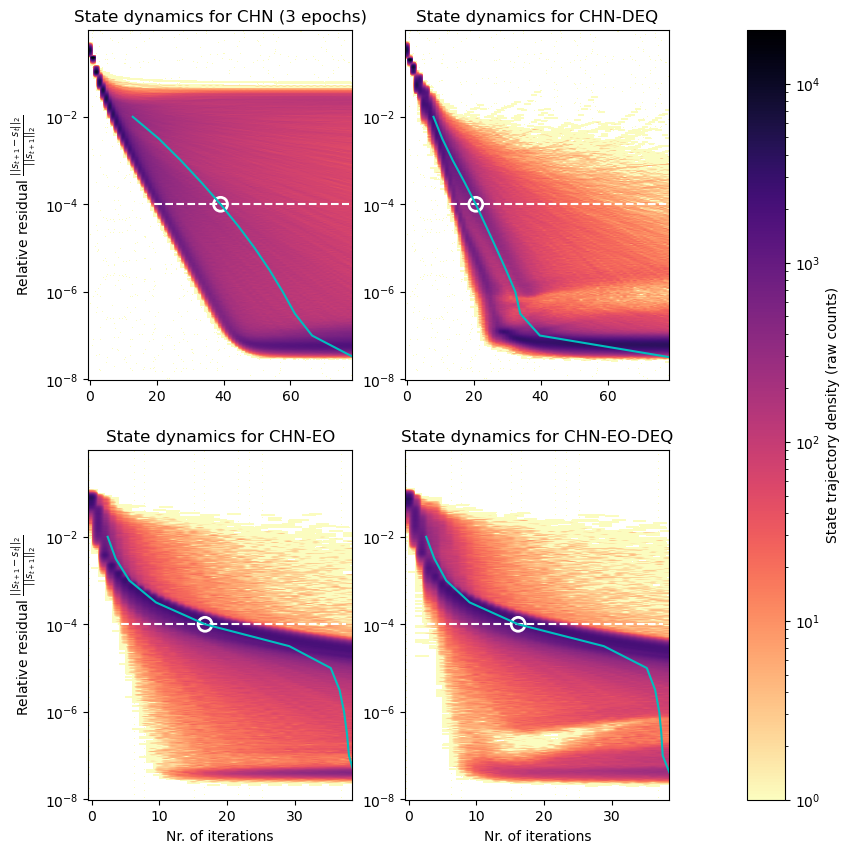

In [24]:
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LogNorm

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Create a LogNorm instance for the colorbar
norm = LogNorm()

# Loop through the dictionary and plot for each key-value pair
for i, key in enumerate([(False, False), (False, True), (True, False), (True, True)]):
    ax = axes[i // 2, i % 2]

    # Plot the code for the tensor associated with the key
    with torch.inference_mode():
        log_rel_residual = torch.cat(all_rel_res[key], dim=1)

        bins = 400
        hists = torch.stack([torch.histc(rr, bins=bins, min=-8, max=0) for rr in log_rel_residual])

        conv_tols = torch.arange(-8, -1.5, 0.5) # log_rel_res convergence criteria
        conv_times = []
        for tol in conv_tols:
            converged_indx = torch.argmax((log_rel_residual < tol).float(), dim=0)
            converged_indx[converged_indx==0] = log_rel_residual.size(0)  # =max number of time steps
            conv_times.append(converged_indx.float().mean())

            if tol == -4.:
                ax.scatter(conv_times[-1], bins//2, marker="o", linewidths=2.,
                           s=100, facecolors='none', edgecolors='w')

        conv_times = torch.stack(conv_times)
        print(conv_times)
        print(conv_tols)

    # Plot 1e-4 convergence line
    nr_of_iters = log_rel_residual.size(0)
    ax.hlines(bins//2, -0.5, nr_of_iters-1.5, colors='w', linestyles='dashed')

    # Plot cyan convergence line
    ax.plot(reversed(conv_times), bins-reversed(conv_tols)*(-bins)//8, color='c')

    # Plot heatmap
    im = ax.imshow(hists.T, origin='lower', norm=norm, cmap='magma_r', aspect='auto')

    # model = 'HAM'
    model = 'CHN'
    if key[0]:
        model += '-EO'
    if key[1]:
        model += '-DEQ'
    if not key[0] and not key[1]:
        model += ' (3 epochs)'
    
    ax.set_title("State dynamics for "+model)

    #Only for bottom row
    if key[0]: ax.set_xlabel('Nr. of iterations')

    #Only for left column
    if not key[1]: ax.set_ylabel(r'Relative residual $\frac{||s_{t+1} - s_t||_2}{||s_{t+1}||_2}$')

    ax.set_yticks(range(0, bins, bins//4))
    ax.set_yticklabels(["$10^{"+str(x)+"}$" for x in range(-8, 0, 2)])

# Add a colorbar using the LogNorm instance
cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=0.1, norm=norm)
cbar.set_label('State trajectory density (raw counts)')

plt.show()
